# Overview

This notebook implements an early evaluation of the strength of the theoretical gateway aggregator model using experimental results.
Compares single experimental setups with the Pinciroli's (2023) theoretical results to generate an intuition of their relationship.

It visualizes the results, calculates the _mean average (percentage) error_ between the results, suggesting how 'off' the results are.
It also calculates Pearson's $r$ to understand the correlation between results.


In [1]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

import datetime
import json
import os
import typing

import pandas as pd
import numpy as np
from scipy.stats import spearmanr

import gssi_experiment.util.util as util
import gssi_experiment.util.notebook_helper as nb_helper
import gssi_experiment.util.stat_helper as stat_helper
import gssi_experiment.util.prometheus_raw_data_helper as prom_data_helper


pincirollis_data_path = (
    "/workspaces/muBench-experiment/gssi_experiment/gateway_offloading/multi_N25.csv"
)
synth_df = pd.read_csv(pincirollis_data_path, header=0)
synth_df.describe()

fig_path = '/workspaces/muBench-experiment/gssi_experiment/gateway_offloading/figures/'

base_path = "/workspaces/muBench-experiment/gssi_experiment/gateway_offloading/results/pinciroli_replication_fin/"

## Dataframe creation


### Initial Construction


In [2]:
TIME_FORMAT = "%Y-%m-%dT%H:%M:%S.000Z"
TIMEFORMAT_2 = "%Y-%m-%d %H:%M:%S"

service_cols = ["gw", "s1", "s2", "s3"]


def get_data_points() -> typing.Iterator:
    for experiment_folder in util.iterate_through_nested_folders(
        base_path, max_depth=3
    ):
        # Calculates delay data
        mubench_file = f"{experiment_folder}/mubench_results.csv"
        exp_df = pd.read_csv(mubench_file, header=0)
        avg_latency = np.average(exp_df["latency_ms"])

        # Reads metadata to calculate s3 intensity
        meta_path = f"{experiment_folder}/metadata.json"
        with open(meta_path, "r", encoding="utf-8") as meta_file:
            metadata = json.loads(meta_file.read())
        cpu_limit = metadata["cmd_arguments"]["cpu_limit"]
        replicas = metadata["cmd_arguments"]["replicas"]
        max_steps = metadata["cmd_arguments"]["simulation_steps"]
        # HACK: add this to the metadata.
        step = int(os.path.basename(os.path.dirname(experiment_folder)).split("_")[0])
        offload = int(os.path.basename(experiment_folder).split("_")[0])
        dashboard_intensity = step / max_steps

        # Calculates CPU utilization data.
        start_time = datetime.datetime.strptime(metadata["start_time"], TIME_FORMAT)
        end_time = datetime.datetime.strptime(metadata["end_time"], TIME_FORMAT)
        utilization_data = prom_data_helper.calculate_average_cpu_time(
            experiment_folder, service_cols, start_time, end_time
        )

        data_point = [
            step,
            max_steps,
            dashboard_intensity,
            avg_latency,
            cpu_limit,
            replicas,
            metadata["start_time"],
            metadata["end_time"],
            offload,
            *utilization_data,
        ]
        yield data_point


cols = [
    "step",
    "max_step",
    "dashboard_intensity",
    "avg_latency_ms",
    "cpu_limit",
    "replicas",
    "experiment_start_time",
    "experiment_end_time",
    "offload",
]
cpu_util_format = "cpu_utilization_{service}"
cpu_columns = [cpu_util_format.format(service=service) for service in service_cols]
cols.extend(cpu_columns)

data_points = get_data_points()

df = pd.DataFrame(data_points, columns=cols)

old_df_len = len(df)
df = df.dropna()
new_df_len = len(df)
if new_df_len != old_df_len:
    print("!!!SOME ROWS WERE REMOVED BECAUSE THEY ARE NAN!!!")
    print(f"The row count was {old_df_len} and now is {new_df_len}.")

df.describe()

Updating initial services to: ['gw.1', 's1', 's2', 's3']
Updating initial services to: ['gw.1', 's1', 's2', 's3']
Updating initial services to: ['gw.2', 's1', 's2', 's3']
Updating initial services to: ['gw.1', 's1', 's2', 's3']
Updating initial services to: ['gw', 's1', 's2.1', 's3']
Retrying to calculate averages with services: ['gw.1', 's1.1', 's2.1', 's3.1']
Updating initial services to: ['gw.1', 's1', 's2', 's3']
Retrying to calculate averages with services: ['gw', 's1', 's2.1', 's3']
Updating initial services to: ['gw.1', 's1', 's2', 's3']
Updating initial services to: ['gw.1', 's1', 's2', 's3']
Updating initial services to: ['gw.2', 's1', 's2', 's3']
Updating initial services to: ['gw.1', 's1', 's2', 's3']
Retrying to calculate averages with services: ['gw', 's1.1', 's2', 's3']
Retrying to calculate averages with services: ['gw', 's1.1', 's2', 's3']
Updating initial services to: ['gw.1', 's1', 's2', 's3']
Updating initial services to: ['gw.2', 's1', 's2', 's3']
Updating initial s

,step,max_step,dashboard_intensity,avg_latency_ms,replicas,offload,cpu_utilization_gw,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3
count,108.000000,108.0,108.000000,108.000000,108.0,108.000000,108.000000,108.000000,108.000000,108.000000
mean,2.500000,5.0,0.500000,658.371812,1.0,5.000000,0.488848,0.629321,0.502933,0.391486
std,1.715787,0.0,0.343157,161.460569,0.0,4.101516,0.274906,0.362025,0.350220,0.320992
min,0.000000,5.0,0.000000,395.408787,1.0,0.000000,0.121917,0.001780,0.001881,0.001879
25%,1.000000,5.0,0.200000,563.580890,1.0,0.000000,0.191526,0.288983,0.148551,0.117243
50%,2.500000,5.0,0.500000,611.899391,1.0,5.000000,0.492658,0.870537,0.488286,0.327045
75%,4.000000,5.0,0.800000,749.184154,1.0,10.000000,0.756088,0.916600,0.816202,0.679783
max,5.000000,5.0,1.000000,977.901883,1.0,10.000000,0.933733,0.945248,0.981062,0.939406


#### Loads Synthetic data


In [3]:
synth_cols = ["N_A", "r_gw", "R0", "Us1", "Us2", "Us3", "Ugw"]
pinc_df = synth_df[synth_cols]

# Calculates offload to merge with.
pinc_df.loc[:, "offload"] = pinc_df["r_gw"].transform(lambda x: int(1 / x))
pinc_df = pinc_df.drop("r_gw", axis=1)

# Calculates s3 intensity to merge with.
pinc_df.loc[:, "dashboard_intensity"] = pinc_df["N_A"].transform(lambda x: x / 25)
pinc_df = pinc_df.drop("N_A", axis=1)

df = pd.merge(df, pinc_df, on=["dashboard_intensity", "offload"])

df.describe()

/tmp/ipykernel_522/1110569621.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pinc_df.loc[:, "offload"] = pinc_df["r_gw"].transform(lambda x: int(1 / x))


,step,max_step,dashboard_intensity,avg_latency_ms,replicas,offload,cpu_utilization_gw,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3,R0,Us1,Us2,Us3,Ugw
count,108.000000,108.0,108.000000,108.000000,108.0,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,1.080000e+02
mean,2.500000,5.0,0.500000,658.371812,1.0,5.000000,0.488848,0.629321,0.502933,0.391486,266.899094,0.667806,0.377602,0.539815,5.184410e-01
std,1.715787,0.0,0.343157,161.460569,0.0,4.101516,0.274906,0.362025,0.350220,0.320992,77.142703,0.377797,0.303272,0.372306,4.146847e-01
min,0.000000,5.0,0.000000,395.408787,1.0,0.000000,0.121917,0.001780,0.001881,0.001879,171.679852,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,5.0,0.200000,563.580890,1.0,0.000000,0.191526,0.288983,0.148551,0.117243,236.121303,0.393067,0.083203,0.208194,6.094990e-20
50%,2.500000,5.0,0.500000,611.899391,1.0,5.000000,0.492658,0.870537,0.488286,0.327045,249.286114,0.841625,0.344327,0.510307,5.878115e-01
75%,4.000000,5.0,0.800000,749.184154,1.0,10.000000,0.756088,0.916600,0.816202,0.679783,268.207337,0.999900,0.677662,0.963067,9.952257e-01
max,5.000000,5.0,1.000000,977.901883,1.0,10.000000,0.933733,0.945248,0.981062,0.939406,501.360385,1.000000,0.803877,0.996558,9.999953e-01


### Reconstruction


In [4]:
averaged_columns = set([*synth_cols, *cpu_columns, "avg_latency_ms", "R0"])
averaged_columns.remove("N_A")
averaged_columns.remove("r_gw")

offloads = sorted(df["offload"].unique())

#### Averaged dataframe


In [5]:
# Calculates an averaged dataset.
avg_df = nb_helper.to_averaged_df(
    df,
    group_on=["dashboard_intensity", "offload"],
    averaged_columns=averaged_columns,
)

avg_df.describe()

averaged_columns={'avg_latency_ms', 'Us2', 'cpu_utilization_gw', 'Ugw', 'R0', 'cpu_utilization_s2', 'Us1', 'cpu_utilization_s1', 'cpu_utilization_s3', 'Us3'}


,step,max_step,avg_latency_ms,replicas,cpu_utilization_gw,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3,R0,Us1,...,std_cpu_utilization_s1,std_cpu_utilization_s2,std_cpu_utilization_s3,std_R0,std_Us1,std_Us2,std_Us3,std_Ugw,dashboard_intensity,offload
count,18.000000,18.0,18.000000,18.0,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,...,18.000000,18.000000,18.000000,18.0,18.0,18.0,18.0,18.0,18.000000,18.00000
mean,2.500000,5.0,658.371812,1.0,0.488848,0.629321,0.502933,0.391486,266.899094,0.667806,...,0.010410,0.008879,0.006695,0.0,0.0,0.0,0.0,0.0,0.500000,5.00000
std,1.757338,0.0,165.225690,0.0,0.281408,0.370607,0.358547,0.328676,79.010836,0.386946,...,0.007066,0.007000,0.004838,0.0,0.0,0.0,0.0,0.0,0.351468,4.20084
min,0.000000,5.0,398.215833,1.0,0.128983,0.002154,0.002582,0.002577,171.679852,0.000000,...,0.000749,0.000977,0.000930,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
25%,1.000000,5.0,562.596599,1.0,0.203955,0.291272,0.148559,0.127514,237.172949,0.430697,...,0.005401,0.005674,0.002901,0.0,0.0,0.0,0.0,0.0,0.200000,0.00000
50%,2.500000,5.0,611.623903,1.0,0.494159,0.864533,0.494818,0.326775,249.286114,0.841625,...,0.009157,0.007228,0.005781,0.0,0.0,0.0,0.0,0.0,0.500000,5.00000
75%,4.000000,5.0,748.026282,1.0,0.735833,0.917625,0.808028,0.680685,264.427536,0.997963,...,0.015939,0.009981,0.009114,0.0,0.0,0.0,0.0,0.0,0.800000,10.00000
max,5.000000,5.0,954.965463,1.0,0.919408,0.930496,0.924525,0.918446,501.360385,1.000000,...,0.025752,0.031096,0.018010,0.0,0.0,0.0,0.0,0.0,1.000000,10.00000


#### Create normalized dataframe

Each entry in the data frame is normalized using the min and max values of the averaged dataframe.

In [6]:
# Calculates a normalized data set
norm_df = None
for offload in offloads:
    sub_norm_df = df[df["offload"] == offload]
    sub_avg_norm_df = avg_df[avg_df["offload"] == offload]

    for col in averaged_columns:
        min_y, max_y = min(sub_avg_norm_df[col]), max(sub_avg_norm_df[col])
        sub_norm_df.loc[:, col] = sub_norm_df[col].transform(
            lambda y: nb_helper.normalize(y, min_y, max_y)
        )

    if norm_df is None:
        norm_df = sub_norm_df
    else:
        norm_df = pd.concat([norm_df, sub_norm_df])

norm_df.describe()

,step,max_step,dashboard_intensity,avg_latency_ms,replicas,offload,cpu_utilization_gw,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3,R0,Us1,Us2,Us3,Ugw
count,108.000000,108.0,108.000000,108.000000,108.0,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,2.500000,5.0,0.500000,0.390120,1.0,5.000000,0.492866,0.676723,0.570970,0.574048,0.292713,0.680055,0.625019,0.627900,0.629807
std,1.715787,0.0,0.343157,0.344721,0.0,4.101516,0.356798,0.390979,0.399829,0.399955,0.350830,0.379499,0.364750,0.365841,0.377257
min,0.000000,5.0,0.000000,-0.016883,1.0,0.000000,-0.060864,-0.001253,-0.001410,-0.001804,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,5.0,0.200000,0.027062,1.0,0.000000,0.185789,0.309096,0.161939,0.170113,0.055202,0.422958,0.378140,0.380574,0.405968
50%,2.500000,5.0,0.500000,0.277791,1.0,5.000000,0.486181,0.935413,0.562195,0.567774,0.105590,0.871728,0.736440,0.741776,0.780967
75%,4.000000,5.0,0.800000,0.609025,1.0,10.000000,0.880533,0.987056,0.983800,0.982504,0.394480,0.999998,0.971175,0.979309,0.998315
max,5.000000,5.0,1.000000,1.043753,1.0,10.000000,1.047856,1.015890,1.064664,1.028925,1.000000,1.000000,1.000000,1.000000,1.000000


#### Create normalized averaged data frame

In [7]:
# Calculates a normalized averaged dataset.
avg_norm_df = avg_df.copy()
for offload in offloads:
    sub_norm_df = avg_norm_df[avg_norm_df["offload"] == offload]
    for col in averaged_columns:
        sub_norm_df, min_y, max_y = nb_helper.normalize_field_and_yield_min_max(
            sub_norm_df, col
        )
        delta_y = max_y - min_y
        std_col = f"std_{col}"
        sub_norm_df.loc[:, std_col] = sub_norm_df[std_col].transform(
            lambda y: y / delta_y
        )
    avg_norm_df.loc[sub_norm_df.index, :] = sub_norm_df

avg_norm_df.describe()

,step,max_step,avg_latency_ms,replicas,cpu_utilization_gw,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3,R0,Us1,...,std_cpu_utilization_s1,std_cpu_utilization_s2,std_cpu_utilization_s3,std_R0,std_Us1,std_Us2,std_Us3,std_Ugw,dashboard_intensity,offload
count,18.000000,18.0,18.000000,18.0,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,...,18.000000,18.000000,18.000000,18.0,18.0,18.0,18.0,18.0,18.000000,18.00000
mean,2.500000,5.0,0.390120,1.0,0.492866,0.676723,0.570970,0.574048,0.292713,0.680055,...,0.011239,0.010129,0.009972,0.0,0.0,0.0,0.0,0.0,0.500000,5.00000
std,1.757338,0.0,0.352779,0.0,0.364477,0.400248,0.409338,0.409500,0.359325,0.388689,...,0.007624,0.007851,0.005754,0.0,0.0,0.0,0.0,0.0,0.351468,4.20084
min,0.000000,5.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000807,0.001063,0.001150,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
25%,1.000000,5.0,0.069170,1.0,0.192131,0.311415,0.165246,0.169384,0.057469,0.453116,...,0.005821,0.006548,0.006213,0.0,0.0,0.0,0.0,0.0,0.200000,0.00000
50%,2.500000,5.0,0.281812,1.0,0.491508,0.929470,0.567029,0.569535,0.105590,0.871728,...,0.009899,0.008132,0.009423,0.0,0.0,0.0,0.0,0.0,0.500000,5.00000
75%,4.000000,5.0,0.597483,1.0,0.836368,0.989469,0.992727,0.988978,0.380991,0.999974,...,0.017242,0.012029,0.014052,0.0,0.0,0.0,0.0,0.0,0.800000,10.00000
max,5.000000,5.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.027794,0.033835,0.019671,0.0,0.0,0.0,0.0,0.0,1.000000,10.00000


# Request Delay


## Visualization


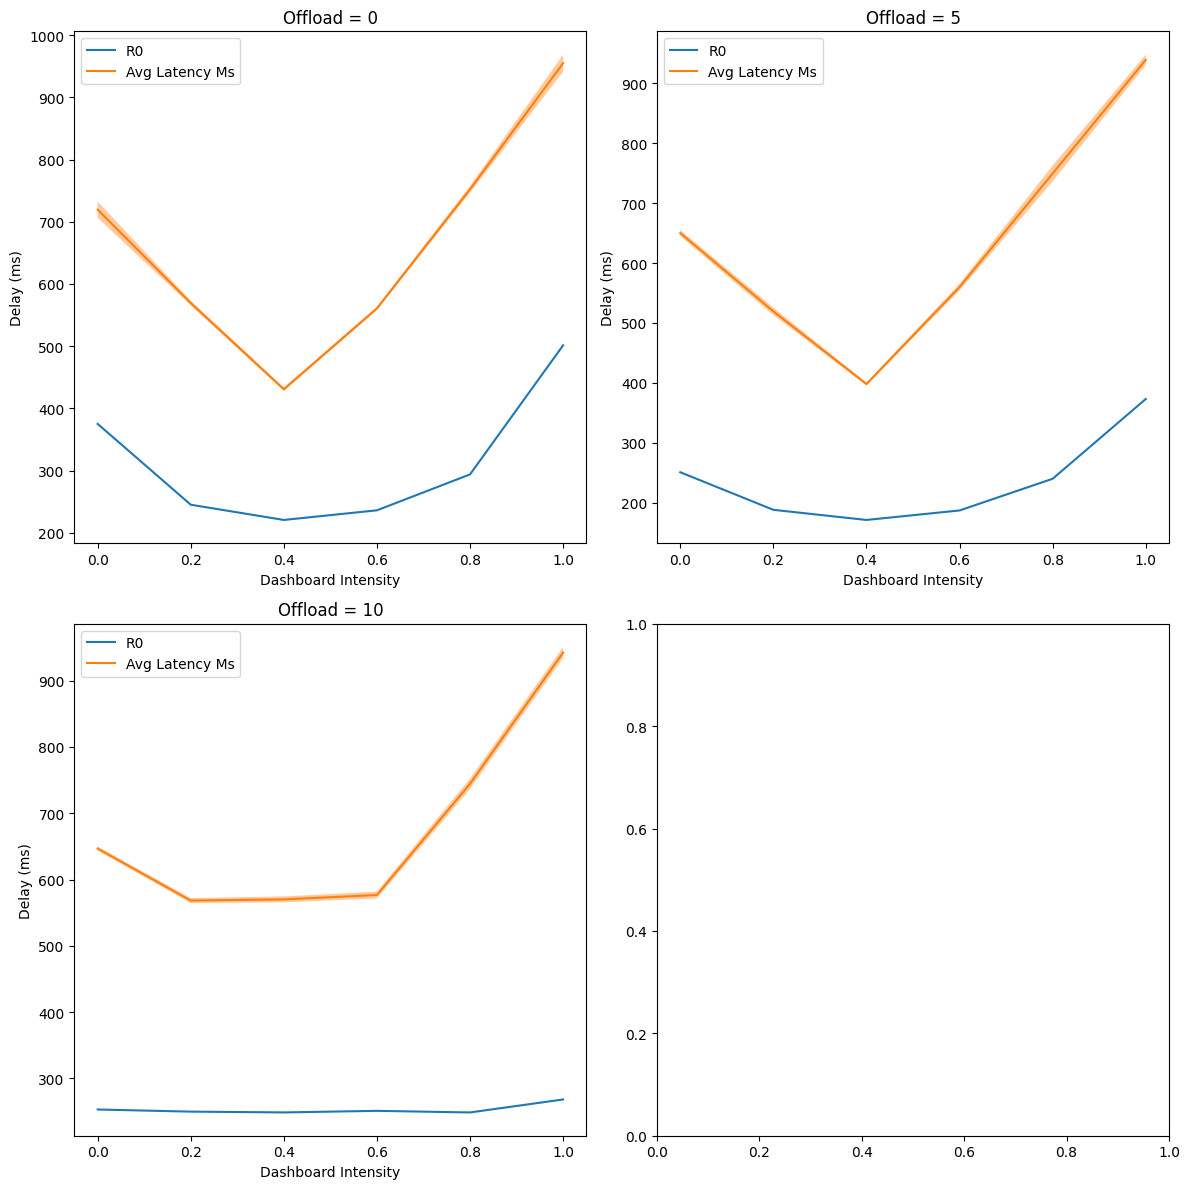

In [8]:
output_path = f'{fig_path}/req_delay_abs.png'

nb_helper.create_multi_figure(
    avg_df, ["R0", "avg_latency_ms"], "dashboard_intensity", "offload", "Delay (ms)", output_path
)

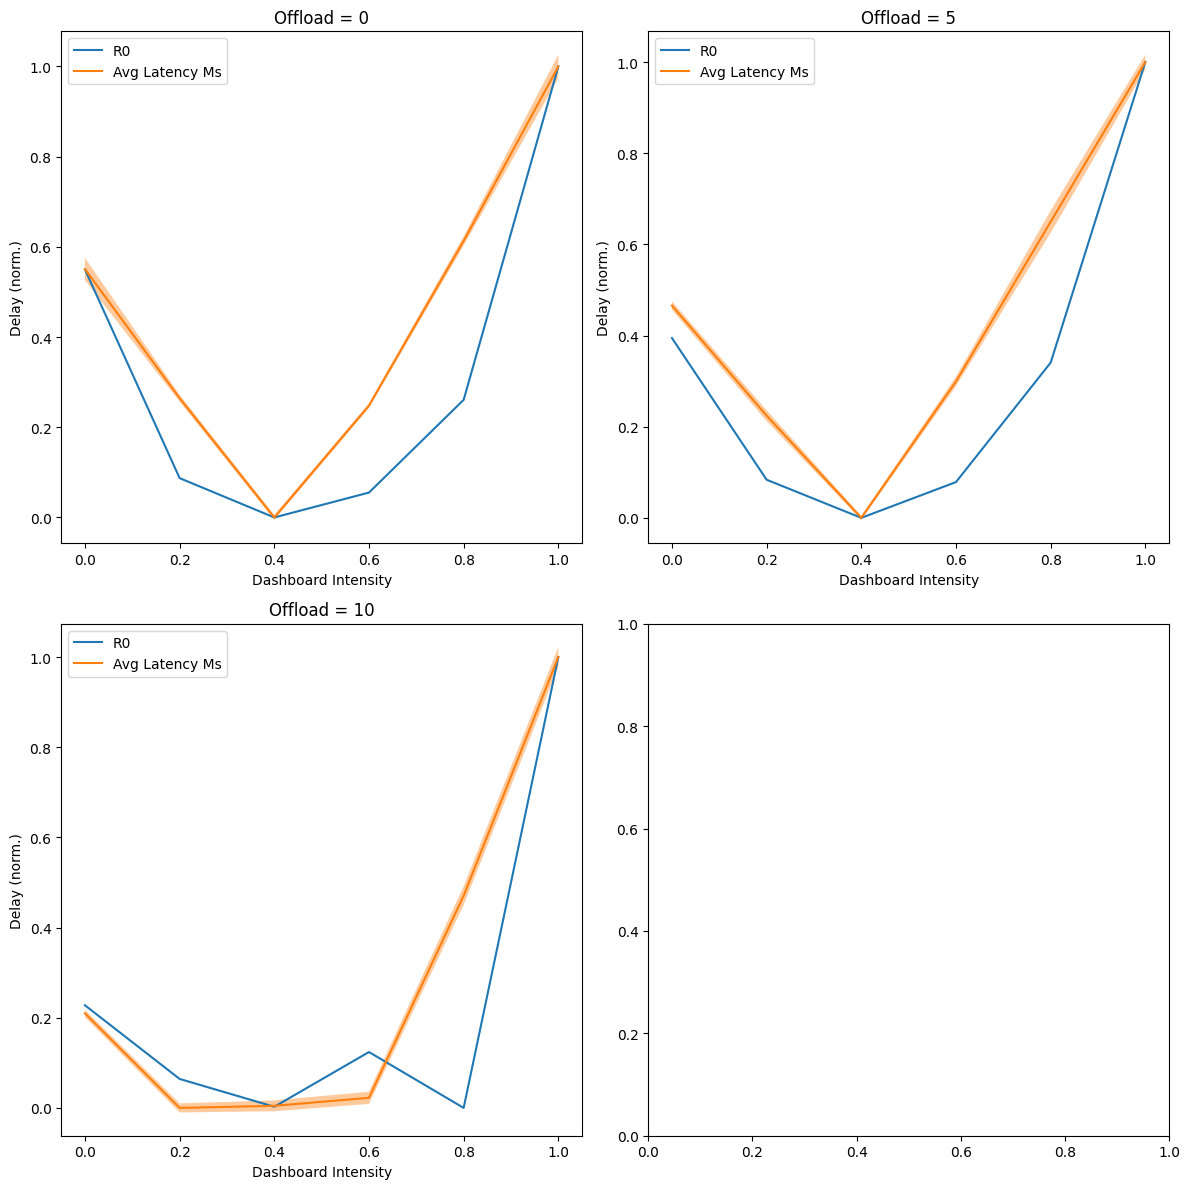

In [9]:
# avg_norm_df = nb_helper.to_averaged_df(df_norm, group_columns, averaged_columns)
output_path = f"{fig_path}/req_delay_norm.png"
nb_helper.create_multi_figure(
    avg_norm_df,
    ["R0", "avg_latency_ms"],
    "dashboard_intensity",
    "offload",
    "Delay (norm.)",
    output_path,
)

## Evaluation


### Compares the delay data set using MAPE and Spearman's r


In [10]:
for offload in sorted(offloads):
    print(f"{offload=}")
    sub_df = norm_df[norm_df["offload"] == offload]
    correlation_coefficient, p_value = spearmanr(sub_df["R0"], sub_df["avg_latency_ms"])

    sig = "significant" if p_value < 0.05 else "insignificant"
    print("Spearman's correlation coefficient:")
    print(f"avg_latency_ms: {correlation_coefficient=:.3f} ({p_value=:.3f} = {sig})")
    print()

offload=0
Spearman's correlation coefficient:
avg_latency_ms: correlation_coefficient=0.930 (p_value=0.000 = significant)

offload=5
Spearman's correlation coefficient:
avg_latency_ms: correlation_coefficient=0.874 (p_value=0.000 = significant)

offload=10
Spearman's correlation coefficient:
avg_latency_ms: correlation_coefficient=0.371 (p_value=0.026 = significant)



### Mean average percentage error

Intuitively, how off the result is on average.

$\displaystyle M = \frac{1}{n}\sum^n_{t=1} \bigg|\frac{A_t - F_t}{A_t}\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.


In [11]:
for offload in sorted(offloads):
    print(f"{offload=}")
    sub_df = df[df["offload"] == offload]
    sub_norm_df = norm_df[norm_df["offload"] == offload]

    absolute_mape = stat_helper.mape(sub_df["R0"], sub_df["avg_latency_ms"])
    eps = 1
    normalized_mape = stat_helper.mape(
        sub_norm_df["R0"] + eps, sub_norm_df["avg_latency_ms"] + eps
    )

    print(f"{absolute_mape=:.2f}%, {normalized_mape=:.2f}% ({eps=})")
    print()

offload=0
absolute_mape=53.32%, normalized_mape=8.98% (eps=1)

offload=5
absolute_mape=62.76%, normalized_mape=8.84% (eps=1)

offload=10
absolute_mape=61.31%, normalized_mape=8.57% (eps=1)



### Mean absolute error

$\displaystyle M = \frac{1}{n}\sum^n_{t=1}\bigg|A_t - F_t\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.


In [12]:
for offload in sorted(offloads):
    print(f"{offload=}")
    sub_df = df[df["offload"] == offload]
    sub_norm_df = norm_df[norm_df["offload"] == offload]

    absolute_mae = stat_helper.mae(sub_df["R0"], sub_df["avg_latency_ms"])
    normalized_mae = 100 * stat_helper.mae(
        sub_norm_df["R0"], sub_norm_df["avg_latency_ms"]
    )

    print(f"{absolute_mae=:.3f}, {normalized_mae=:.2f}%")
    print()

offload=0
absolute_mae=352.538, normalized_mae=12.75%

offload=5
absolute_mae=400.451, normalized_mae=12.63%

offload=10
absolute_mae=421.429, normalized_mae=11.29%



# CPU Utilization


## Visualization


### Absolute


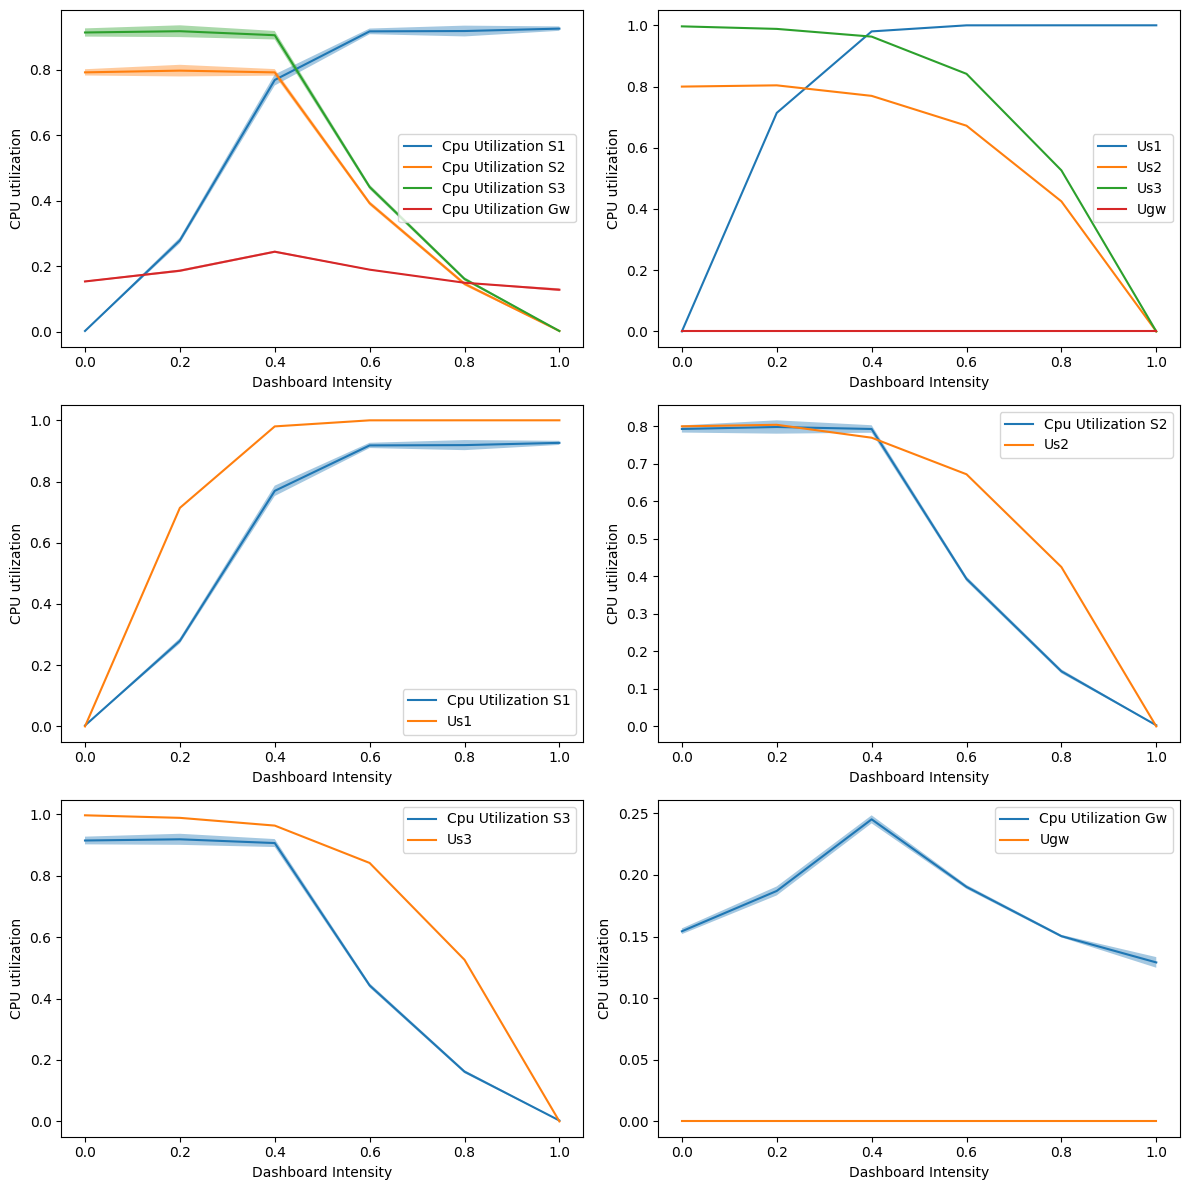

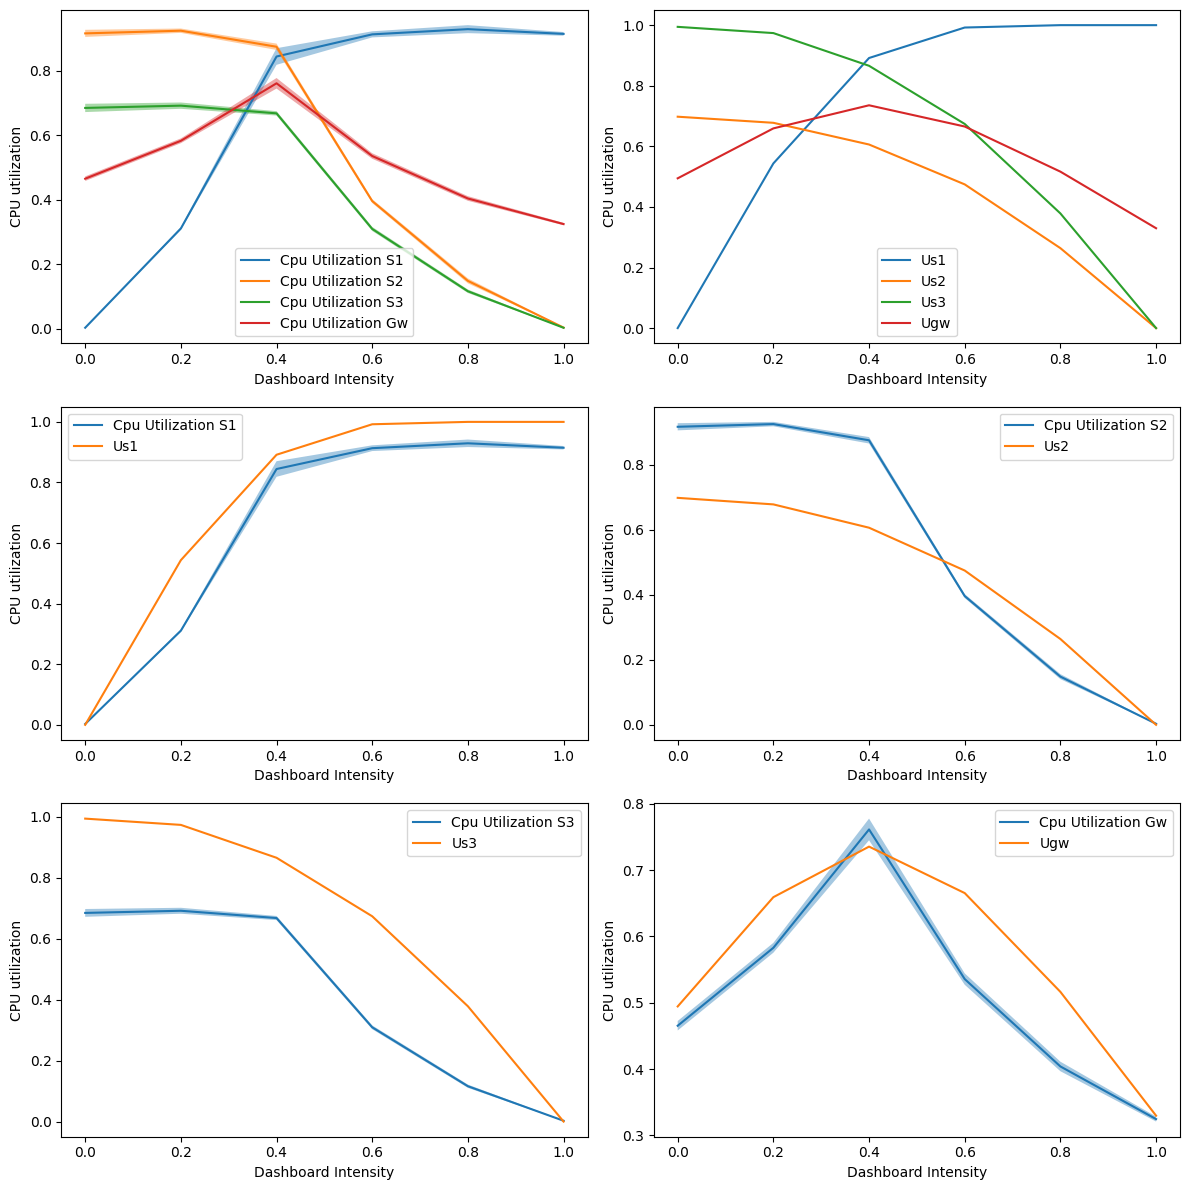

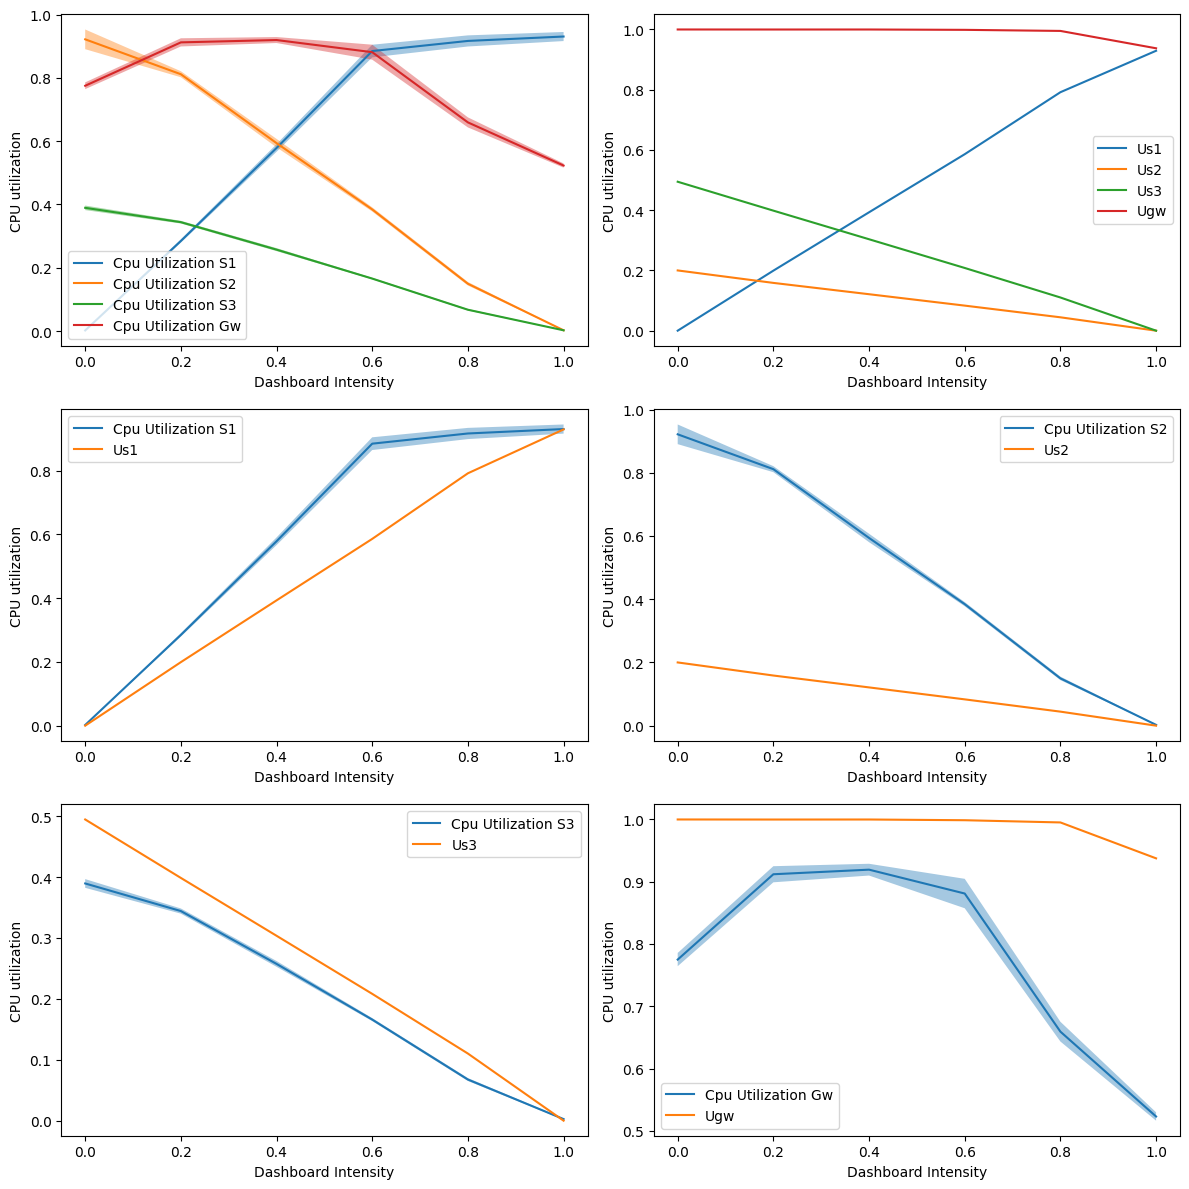

In [13]:
comparison_tuples = [
    (
        "cpu_utilization_s1",
        "cpu_utilization_s2",
        "cpu_utilization_s3",
        "cpu_utilization_gw",
    ),
    ("Us1", "Us2", "Us3", "Ugw"),
    ("cpu_utilization_s1", "Us1"),
    ("cpu_utilization_s2", "Us2"),
    ("cpu_utilization_s3", "Us3"),
    ("cpu_utilization_gw", "Ugw"),
]

for offload in offloads:
    sub_df:pd.DataFrame = avg_df[avg_df['offload'] == offload]
    sub_df = sub_df.sort_values("dashboard_intensity")
    output_path = f'{fig_path}/cpu_util_abs_offload_{offload}.png'
    nb_helper.create_plot_comparisons(comparison_tuples, sub_df, "dashboard_intensity", output_path)

### Normalized


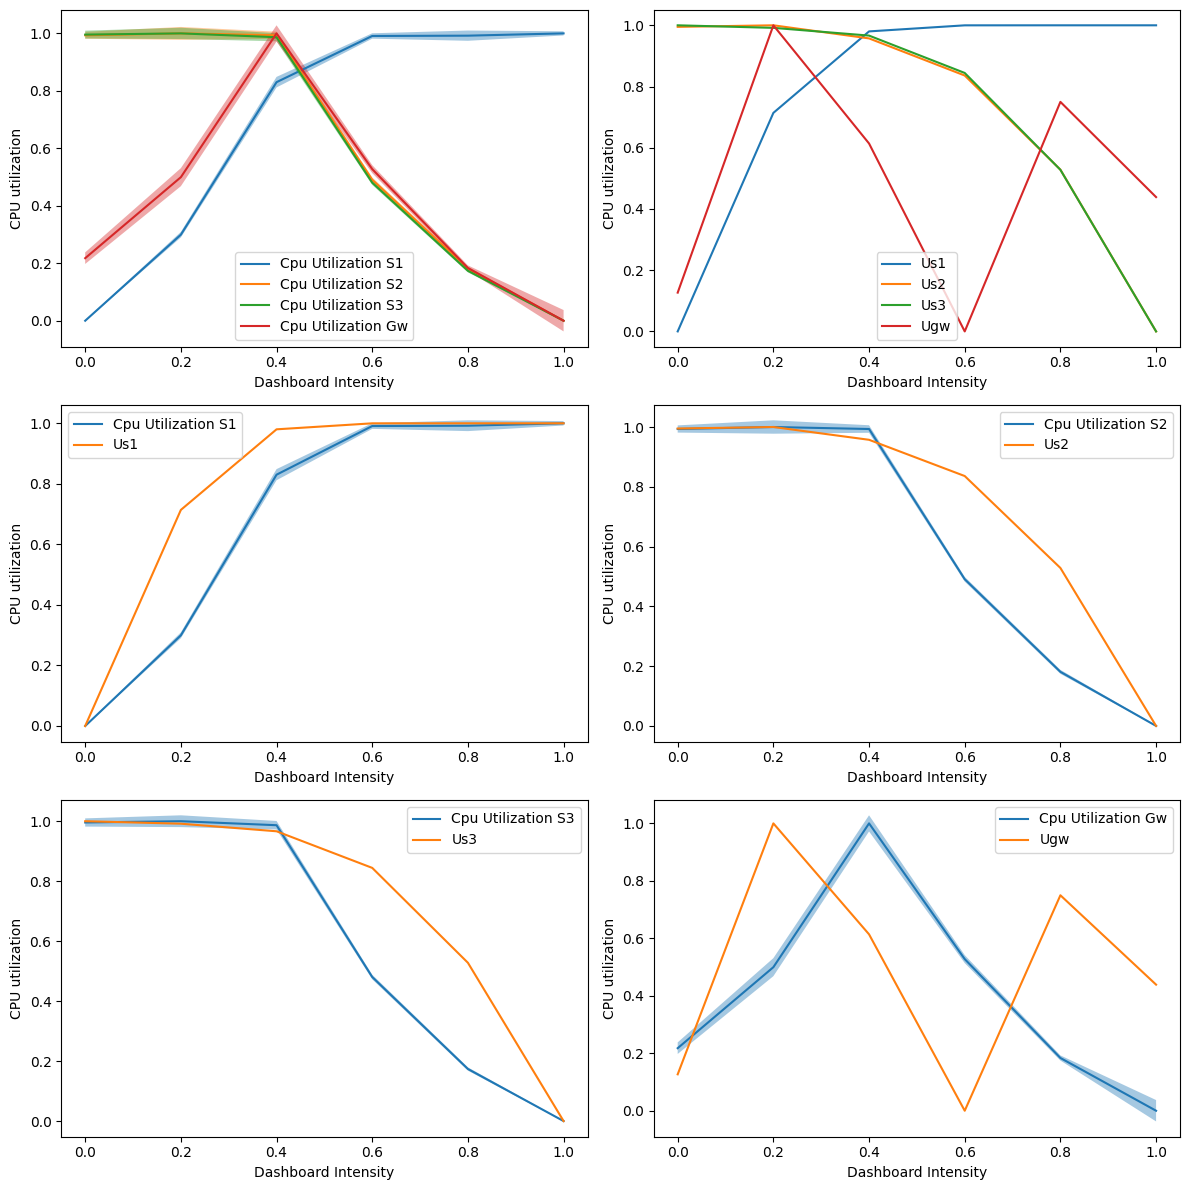

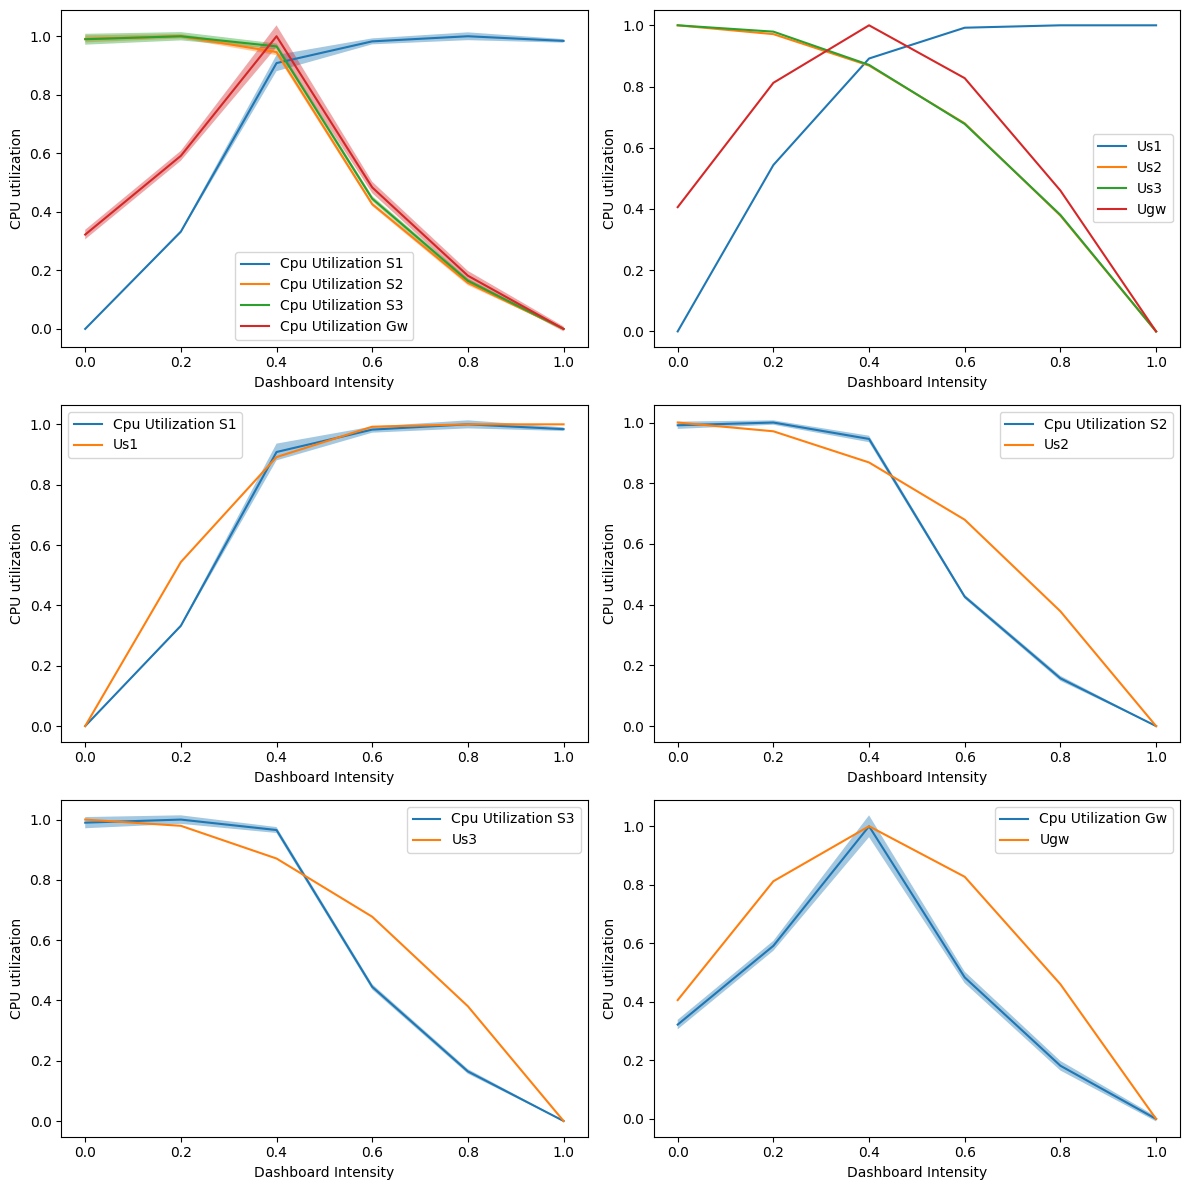

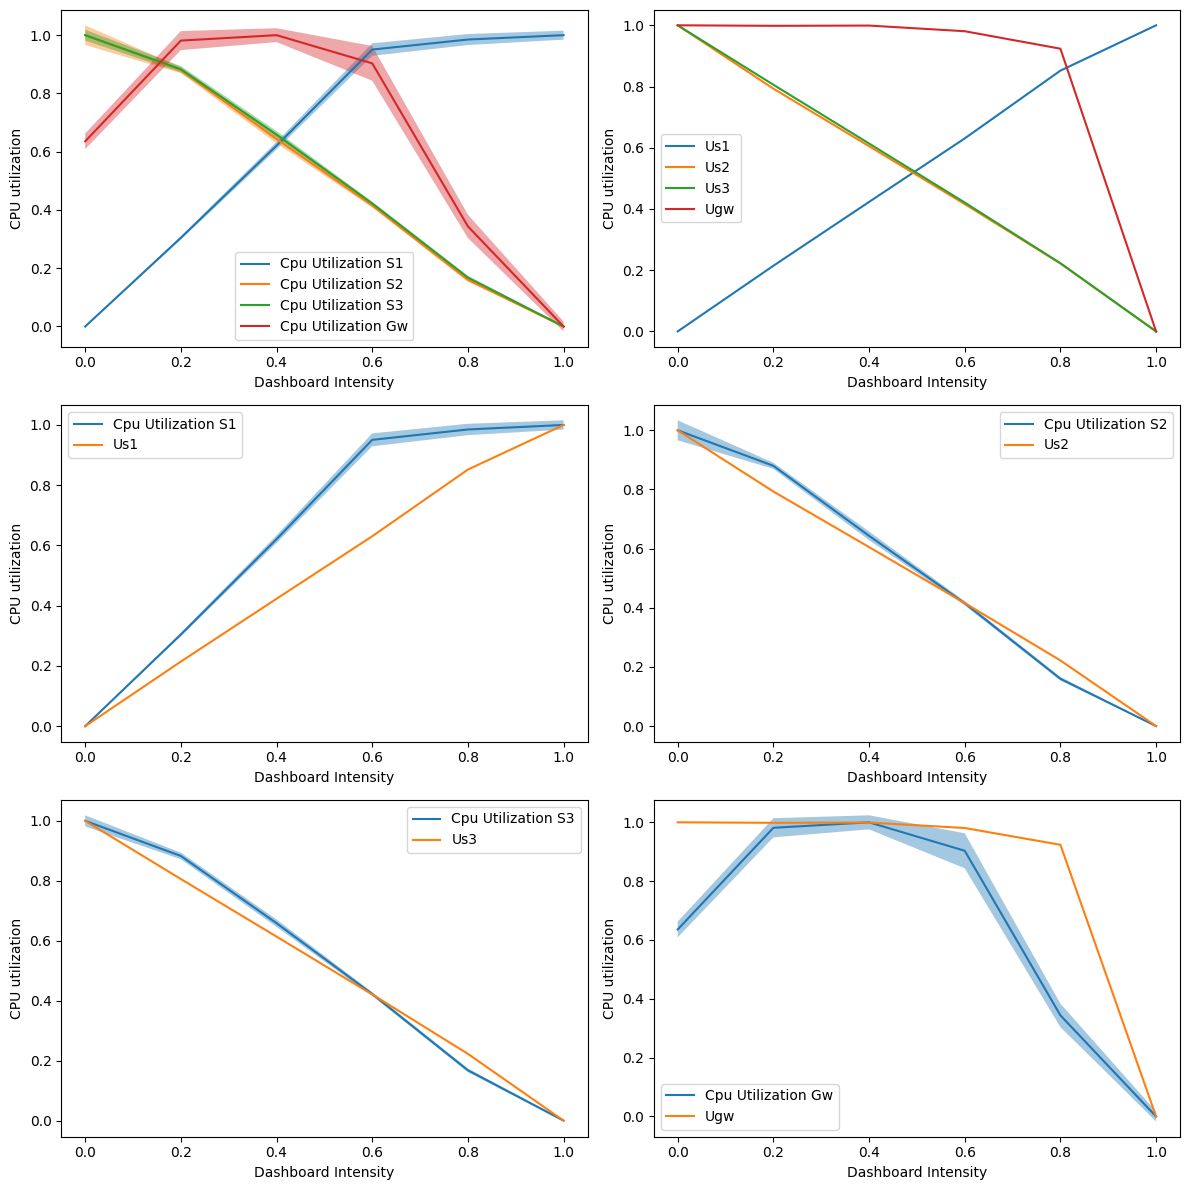

In [14]:
comparison_tuples = [
    (
        "cpu_utilization_s1",
        "cpu_utilization_s2",
        "cpu_utilization_s3",
        "cpu_utilization_gw",
    ),
    ("Us1", "Us2", "Us3", "Ugw"),
    ("cpu_utilization_s1", "Us1"),
    ("cpu_utilization_s2", "Us2"),
    ("cpu_utilization_s3", "Us3"),
    ("cpu_utilization_gw", "Ugw"),
]

for offload in offloads:
    avg_sub_df: pd.DataFrame = avg_norm_df[avg_norm_df["offload"] == offload]
    avg_sub_df = avg_sub_df.sort_values("dashboard_intensity")
    output_path = f'{fig_path}/cpu_util_norm_offload_{offload}.png'
    nb_helper.create_plot_comparisons(
        comparison_tuples, avg_sub_df, "dashboard_intensity", output_path
    )

## Evaluation


In [15]:
comparison_tuples = [
    ("cpu_utilization_s1", "Us1"),
    ("cpu_utilization_s2", "Us2"),
    ("cpu_utilization_s3", "Us3"),
    ("cpu_utilization_gw", "Ugw"),
]

### Spearman's correlation coefficient


In [16]:
print("Spearman's correlation coefficient:")

for offload in offloads:
    print(f"{offload=}")
    sub_df = df[df['offload'] == offload]

    for real, expected in comparison_tuples:
        correlation_coefficient, p_value = spearmanr(sub_df[expected], sub_df[real])

        sig = "significant" if p_value < 0.05 else "insignificant"
        # Display the result
        print(f"{real}: {correlation_coefficient:.3f} ({p_value=:.3f} = {sig})")
    print()

Spearman's correlation coefficient:
offload=0
cpu_utilization_s1: 0.905 (p_value=0.000 = significant)
cpu_utilization_s2: 0.885 (p_value=0.000 = significant)
cpu_utilization_s3: 0.900 (p_value=0.000 = significant)
cpu_utilization_gw: -0.003 (p_value=0.986 = insignificant)

offload=5
cpu_utilization_s1: 0.875 (p_value=0.000 = significant)
cpu_utilization_s2: 0.944 (p_value=0.000 = significant)
cpu_utilization_s3: 0.933 (p_value=0.000 = significant)
cpu_utilization_gw: 0.874 (p_value=0.000 = significant)

offload=10
cpu_utilization_s1: 0.960 (p_value=0.000 = significant)
cpu_utilization_s2: 0.986 (p_value=0.000 = significant)
cpu_utilization_s3: 0.986 (p_value=0.000 = significant)
cpu_utilization_gw: 0.614 (p_value=0.000 = significant)



### Mean average (percentage) error


In [17]:
for offload in offloads:
    print()
    print(f"{offload=}")
    sub_df = df[df["offload"] == offload]
    sub_norm_df = norm_df[norm_df["offload"] == offload]

    for real, expected in comparison_tuples:
        mape_score = stat_helper.mape(sub_df[expected], sub_df[real])
        mae_score = 100 *  stat_helper.mae(sub_df[expected], sub_df[real])
        print(f"{real}: {mape_score=:.2f}%, {mae_score=:.2f}%")

        eps = 1
        norm_mape_score = stat_helper.mape(sub_norm_df[expected] + eps, sub_norm_df[real] + eps)
        norm_mae_score = 100 * stat_helper.mae(sub_norm_df[expected], sub_norm_df[real])
        print(f"{real}: {norm_mape_score=:.2f}% ({eps=}), {norm_mae_score=:.2f}%")
        print()

    print()


offload=0
cpu_utilization_s1: mape_score=51.45%, mae_score=14.74%
cpu_utilization_s1: norm_mape_score=6.98% (eps=1), norm_mae_score=9.97%

cpu_utilization_s2: mape_score=61.13%, mae_score=10.16%
cpu_utilization_s2: norm_mape_score=9.33% (eps=1), norm_mae_score=12.65%

cpu_utilization_s3: mape_score=73.03%, mae_score=16.24%
cpu_utilization_s3: norm_mape_score=9.54% (eps=1), norm_mae_score=12.78%

cpu_utilization_gw: mape_score=100.00%, mae_score=17.60%
cpu_utilization_gw: norm_mape_score=31.10% (eps=1), norm_mae_score=41.84%



offload=5
cpu_utilization_s1: mape_score=34.36%, mae_score=8.63%
cpu_utilization_s1: norm_mape_score=3.19% (eps=1), norm_mae_score=4.58%

cpu_utilization_s2: mape_score=46.59%, mae_score=15.52%
cpu_utilization_s2: norm_mape_score=7.17% (eps=1), norm_mae_score=9.90%

cpu_utilization_s3: mape_score=93.36%, mae_score=23.64%
cpu_utilization_s3: norm_mape_score=6.90% (eps=1), norm_mae_score=9.68%

cpu_utilization_gw: mape_score=12.74%, mae_score=6.31%
cpu_utilization